In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import many_stop_words
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from autocorrect import Speller
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder

In [2]:
check = Speller(lang='en')
le = LabelEncoder()

In [3]:
import json

with open("normalize_mapping.json") as normalize_json_file_obj:
    normalize_json = json.load(normalize_json_file_obj)

    

In [4]:
train, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

In [5]:
#stop_words = list(set(stopwords.words("english")))
lemmatizer = WordNetLemmatizer()
stop_words = many_stop_words.get_stop_words("en")
sb_stemmer = SnowballStemmer(language='english')

In [6]:
train.duplicated().sum()

0

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
set(train.keyword.unique()) - set(test.keyword.unique())

set()

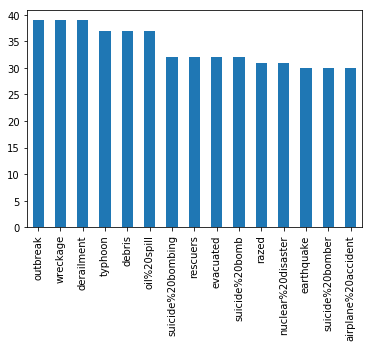

In [10]:
train[(train["target"] == 1)].keyword.value_counts()[0:15].plot.bar()


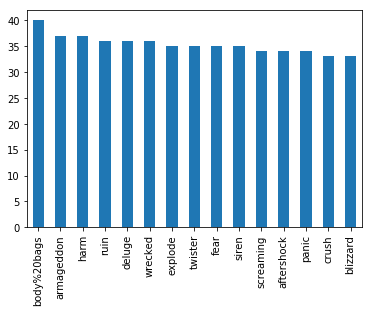

In [11]:
train[(train["target"] == 0)].keyword.value_counts()[0:15].plot.bar()

In [12]:
train["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in train["keyword"]]
test["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in test["keyword"]]

In [13]:
train["encoded_clean_keyword"] = le.fit_transform(train["clean_keyword"])
test["encoded_clean_keyword"] = le.transform(test["clean_keyword"])

In [14]:
def clean_text(tweet_df):
    new_tweet_list = []
    for each_tweet in tqdm(tweet_df):
        each_tweet = each_tweet.lower()
        each_tweet = re.sub(r"https?:[^\s]+(?= |$)", "", each_tweet)
        each_tweet = re.sub(r"@[^\s]+", "", each_tweet)
        each_tweet = re.sub(r"&amp;|\||Û|û", "", each_tweet)
        each_tweet = re.sub(r"[^a-z ]", "", each_tweet)
        twitter_slangs = r"|".join(["rt","tweet"])
        each_tweet = re.sub(twitter_slangs, "", each_tweet)
        each_tweet = check(each_tweet)
        each_tweet = " ".join([lemmatizer.lemmatize(each_word) for each_word in each_tweet.split() if each_word not in stop_words])
        each_tweet = " ".join([normalize_json.get(each_word, each_word) for each_word in each_tweet.split()])
        #each_tweet = " ".join([sb_stemmer.stem(each_word) for each_word in word_tokenize(each_tweet) if each_word not in stop_words])

        
        new_tweet_list.append(each_tweet)
    new_tweet_df = pd.DataFrame(new_tweet_list)
    return new_tweet_df
train["clean_text"] = clean_text(train["text"])
test["clean_text"] = clean_text(test["text"])

100%|██████████| 3263/3263 [04:01<00:00, 13.49it/s]


In [15]:
def clean_text_after(tweet_df):
    new_tweet_list = []
    for each_tweet in tqdm(tweet_df):
        twitter_common_words = r"|".join(["news", "videos", "time", "day", "video"])
        re.sub(twitter_common_words, "", each_tweet)

        each_tweet = " ".join([sb_stemmer.stem(each_word) for each_word in word_tokenize(each_tweet) if each_word not in stop_words])
        new_tweet_list.append(each_tweet)
    new_tweet_df = pd.DataFrame(new_tweet_list)
    return new_tweet_df
train["clean_text"] = clean_text_after(train["clean_text"])
test["clean_text"] = clean_text_after(test["clean_text"])

100%|██████████| 3263/3263 [00:00<00:00, 7854.15it/s]


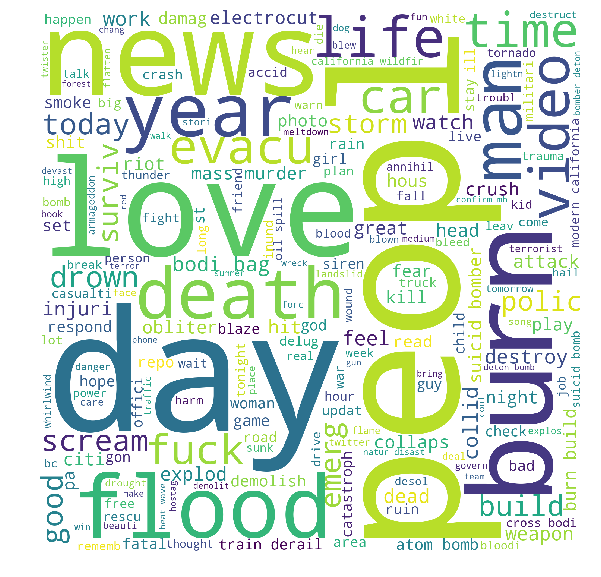

In [16]:
full_data = " ".join(train["clean_text"])
wordcloud = WordCloud(width = 2000, height = 2000,
                      background_color='white',
                min_font_size = 10).generate(full_data) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [153]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [112]:
from sklearn.model_selection import train_test_split
x_train_df, x_val_df, y_train, y_val = train_test_split(train, train["target"], test_size=0.1)

In [113]:
x_train, x_val, x_test = x_train_df["clean_text"], x_val_df["clean_text"], test["clean_text"]

In [114]:
x_train_key, x_val_key, x_test_key = x_train_df["encoded_clean_keyword"], x_val_df["encoded_clean_keyword"], test["encoded_clean_keyword"]

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1, 4))
train_tfidf = tfidf.fit_transform(x_train)

In [116]:
val_tfidf = tfidf.transform(x_val)

In [117]:
test_tfidf = tfidf.transform(x_test)

In [118]:
len(train_tfidf.todense())

6851

In [119]:
train_encoded_clean_keyword = x_train_key.to_numpy()
val_encoded_clean_keyword = x_val_key.to_numpy()
test_encoded_clean_keyword = x_test_key.to_numpy()

In [120]:
x_train_key.shape, train_tfidf.toarray().shape

((6851,), (6851, 11973))

In [121]:
import numpy as np

In [122]:
x_train_tfidf_key = np.array([np.append(tfidf_array, encoded_keyword) for tfidf_array, encoded_keyword in zip(train_tfidf.toarray(), train_encoded_clean_keyword)])
x_val_tfidf_key = np.array([np.append(tfidf_array, encoded_keyword) for tfidf_array, encoded_keyword in zip(val_tfidf.toarray(), val_encoded_clean_keyword)])
x_test_tfidf_key = np.array([np.append(tfidf_array, encoded_keyword) for tfidf_array, encoded_keyword in zip(test_tfidf.toarray(), test_encoded_clean_keyword)])

In [123]:
train_encoded_clean_keyword_ind = np.array([np.array([each]) for each in train_encoded_clean_keyword])
val_encoded_clean_keyword_ind = np.array([np.array([each]) for each in val_encoded_clean_keyword])
test_encoded_clean_keyword_ind = np.array([np.array([each]) for each in test_encoded_clean_keyword])

In [124]:
from sklearn.linear_model import LogisticRegression
logistic_regression_1 = LogisticRegression(C=0.5, solver="sag")
logistic_regression_1.fit(train_tfidf, y_train)
print(logistic_regression_1.score(train_tfidf, y_train))
print(logistic_regression_1.score(val_tfidf, y_val))

0.8569551890235002
0.7900262467191601


In [125]:
logistic_regression_2 = LogisticRegression(C=0.5, solver="sag")
logistic_regression_2.fit(train_encoded_clean_keyword_ind, y_train)
logistic_regression_2.score(val_encoded_clean_keyword_ind, y_val)

/home/utkarsh/projects/python3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.536745406824147

In [126]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(train_tfidf, y_train)
print(knn_clf.score(train_tfidf, y_train))
print(knn_clf.score(val_tfidf, y_val))

0.7558020726901182
0.6732283464566929


In [127]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_clf = DecisionTreeClassifier()

In [128]:
decision_tree_clf.fit(train_encoded_clean_keyword_ind, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [129]:
decision_tree_clf.score(train_encoded_clean_keyword_ind, y_train)

0.7479200116771274

In [130]:
decision_tree_clf.score(val_encoded_clean_keyword_ind, y_val)

0.7204724409448819

In [131]:
pred_result_logistic_1 = logistic_regression_1.predict_proba(val_tfidf)
pred_result_dt = decision_tree_clf.predict_proba(val_encoded_clean_keyword_ind)

In [132]:
ensamble_result = pred_result_logistic_1 * 0.75 + pred_result_dt * 0.25
ensamble_result = np.argmax(ensamble_result, axis=1)

In [133]:
prediction = logistic_regression_1.predict(val_tfidf)

In [172]:
pred_result_logistic_1

array([[0.64704764, 0.35295236],
       [0.57563657, 0.42436343],
       [0.71766697, 0.28233303],
       ...,
       [0.29064888, 0.70935112],
       [0.72842825, 0.27157175],
       [0.69447027, 0.30552973]])

In [254]:
def check_accuracy(pre_results, original_result=[], threshold=0.5):
    if not list(original_result):
        original_result = np.full((len(pre_results)), 0)
    output_list = []
    count = 0
    for each_pre_result, each_org_result in zip(pre_results, original_result):
        if each_pre_result[0] > threshold:
            output = 0
        else:
            output = 1
        if each_org_result == output:
            count += 1
        output_list.append(output)
    print(count/len(pre_results))
    return np.array(output_list)
check_accuracy(pred_result_logistic_1, y_val, threshold=0.55)


0.2099737532808399


array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,

In [160]:
wrong_result = [(sent, each_pre, prob[1]) for index, sent, each_pre, each_or, prob in zip(range(1,len(x_val) + 1), x_val, prediction, y_val, pred_result_logistic_1) if each_pre != each_or]

In [161]:
wrong_result = pd.DataFrame(wrong_result, columns=["Sentence", "Wrong Label", "Score"])
wrong_result.to_csv("wrong_result.csv", index=False)

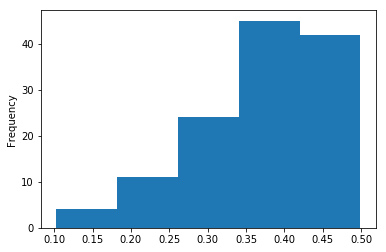

In [171]:
wrong_result[(wrong_result["Wrong Label"] == 0)]["Score"].plot.hist(bins=5)

In [137]:
from sklearn.metrics import classification_report

In [138]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.75      0.92      0.82       409
           1       0.87      0.64      0.74       353

    accuracy                           0.79       762
   macro avg       0.81      0.78      0.78       762
weighted avg       0.80      0.79      0.78       762



In [139]:
prediction_result = logistic_regression_1.predict(test_tfidf)

In [49]:
prediction_result_1 = logistic_regression_1.predict_proba(test_tfidf)

In [201]:
prediction_result = check_accuracy(prediction_result_1, threshold=0.53)

0.6365307998774135


In [50]:
prediction_result_2 = decision_tree_clf.predict_proba(test_encoded_clean_keyword_ind)

In [51]:
prediction_result_2

array([[0.26415094, 0.73584906],
       [0.26415094, 0.73584906],
       [0.26415094, 0.73584906],
       ...,
       [0.26415094, 0.73584906],
       [0.26415094, 0.73584906],
       [0.26415094, 0.73584906]])

In [52]:
prediction_result = prediction_result_1 * 0.8 + prediction_result_2 * 0.2
prediction_result = np.amax(prediction_result, axis=1)

In [202]:
output_result = pd.DataFrame()

In [141]:
test_ids_df = pd.DataFrame(test["id"])

In [203]:
output_result["target"] = prediction_result

In [204]:
len(output_result), len(test_ids_df)

(3263, 3263)

In [205]:
output = pd.concat([test_ids_df.reset_index(drop=True),output_result.reset_index(drop=True)], axis=1)

In [206]:
output["id"]

0           0
1           2
2           3
3           9
4          11
        ...  
3258    10861
3259    10865
3260    10868
3261    10874
3262    10875
Name: id, Length: 3263, dtype: int64

In [207]:
output.to_csv("submisson.csv", index=False)

In [215]:
pred_result_logistic_1 = pred_result_logistic_1[:, 1]

In [216]:
pred_result_logistic_1

array([0.35295236, 0.42436343, 0.28233303, 0.7107087 , 0.33907476,
       0.66454626, 0.217409  , 0.50861543, 0.38786182, 0.23961204,
       0.17105955, 0.40464011, 0.48694498, 0.52983383, 0.6845841 ,
       0.17036633, 0.4003464 , 0.19327997, 0.22370134, 0.35974286,
       0.48152029, 0.49129973, 0.52805312, 0.47808515, 0.81221953,
       0.35926613, 0.5088177 , 0.66739139, 0.61012397, 0.61910269,
       0.50034697, 0.45390098, 0.55620928, 0.51761796, 0.38125458,
       0.82062825, 0.52537544, 0.34620331, 0.28556735, 0.23048922,
       0.33990615, 0.36351037, 0.29740064, 0.53722724, 0.60713217,
       0.21419828, 0.6543142 , 0.6690713 , 0.18130772, 0.58592829,
       0.2586957 , 0.43654237, 0.23833288, 0.37212625, 0.37356722,
       0.65965422, 0.38755197, 0.69151084, 0.35691837, 0.36342474,
       0.29940648, 0.62244134, 0.44347353, 0.54367893, 0.63066227,
       0.3232643 , 0.23298772, 0.43156376, 0.88532332, 0.44247432,
       0.34750991, 0.29214396, 0.21375519, 0.20196909, 0.37283

Area Under the Curve :  0.8594512976443618


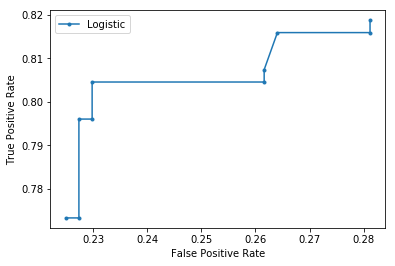

In [240]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_val, pred_result_logistic_1)
lr_fpr, lr_tpr, threshold  = roc_curve(y_val, pred_result_logistic_1)
print("Area Under the Curve : ", lr_auc)
pyplot.plot(lr_fpr[125:135], lr_tpr[125:135], marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [239]:
np.where(0.8045325779036827)

(array([0]),)

In [250]:
threshold[130]

0.3894784590245262

In [241]:
lr_tpr[130], lr_fpr[130]

(0.8045325779036827, 0.2616136919315403)